# Experiment Results and Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import re

## 1. Isolating load time

Run the `round_robin.py` script with different arguments for different experiment parameters. Use the `-b` option so that the mock client blocks on each request.

```sh
python round_robin.py MODEL_NAME -b [-n NUM_MODELS] [-t TP_WORLD_SIZE] [-p PP_WORLD_SIZE] [-r NUM_REQUESTS]
```

Then run the cells below with `debug = False` to extract time data from logs.

For reference, Perlmutter GPU nodes have 4x A100 GPUs per mode, each with a PCIe 4.0 x16 CPU-GPU link that has 32 GB/s bandwidth.

### 1.1. Scaling number of GPUs

In [2]:
cwd = globals()['_dh'][0]
debug = False
if debug:
    # Experiment parameters to debug this notebook
    model_name = "opt-6.7b"
    parallel_configs = [(1, 1), (2, 1), (2, 1), (1, 2), (1, 2), (1, 1)]
else:
    # True experiment parameters
    model_name = "opt-13b"
    parallel_configs = [(1, 1), (2, 1), (4, 1), (1, 2), (1, 4), (2, 2)]
num_models = 2
num_requests = 24


def get_log_dir(tp, pp):
    s = "rr"
    s += f"_{model_name}"
    s += f"_n{num_models}"
    s += f"_t{tp}"
    s += f"_p{pp}"
    s += f"_r{num_requests}"
    s += "_b"
    return join(cwd, s)


def round_robin_times(tp=1, pp=1):
    offload_times = []
    load_times = []
    model_times = []
    total_times = []

    log_dir = get_log_dir(tp, pp)
    with open(join(log_dir, "rank_0_master.log"), "r") as file:
        for line in file:
            if "loaded: False" in line:
                t = re.search(r"time: (\d+\.\d+)", line).group(1)
                offload_times.append(float(t))
            elif "loaded: True" in line:
                t = re.search(r"time: (\d+\.\d+)", line).group(1)
                load_times.append(float(t))
            elif "batch size" in line:
                t = re.search(r"time: (\d+\.\d+)", line).group(1)
                model_times.append(float(t))
    
    with open(join(log_dir, "client.log"), "r") as file:
        for line in file:
            t = re.search(r"time: (\d+\.\d+)", line).group(1)
            total_times.append(float(t))

    # Remove warm up requests
    return (
        offload_times[3:],
        load_times[4:],
        model_times[4:],
        total_times[4:],
    )


[[1.2376     1.35045    0.04       1.40813228]
 [0.63195    0.7324     0.04745    0.80104741]
 [0.44695    0.68865    0.0495     0.76103365]
 [0.6212     0.85815    0.0486     0.92355763]
 [0.3795     0.64455    0.06065    0.72190746]
 [0.31835    0.4231     0.0574     0.501713  ]]


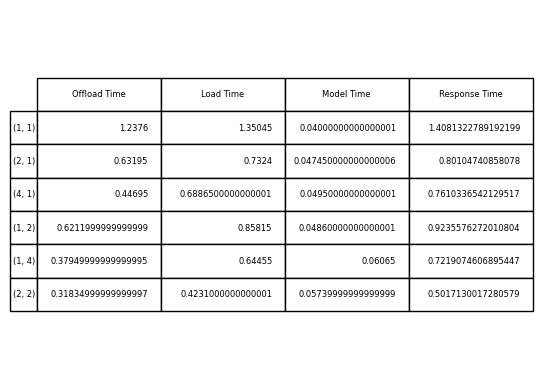

In [3]:
times = []
for pc in parallel_configs:
    times.append(round_robin_times(*pc))

times = np.array(times) # (parallel_config, timer, request)
mean_times = np.mean(times, axis=2)
print(mean_times)

rows = [str(p) for p in parallel_configs]
cols = ["Offload Time", "Load Time", "Model Time", "Response Time"]
plt.axis("off")
plt.axis("tight")
tab = plt.table(mean_times, rowLabels=rows, colLabels=cols, loc="center")
tab.scale(1, 2)
plt.show()

#### 1.1.1. Scaling TP

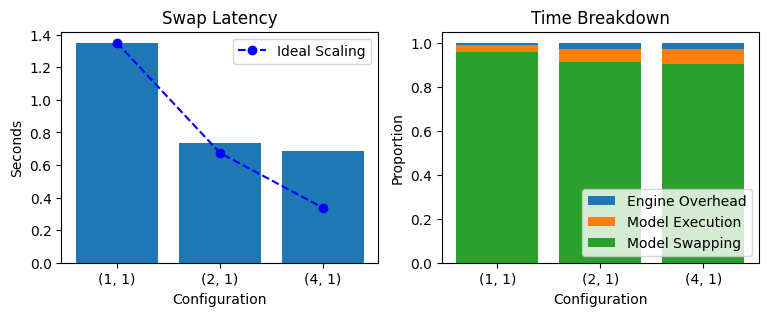

In [6]:
x = ["(1, 1)", "(2, 1)", "(4, 1)"]
mean_scale = mean_times[[0, 1, 2], :]
mean_resp = mean_scale[:, 3]

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
# axs[0].bar(x, mean_resp)
# axs[0].plot(x, [mean_resp[0] / i for i in [1, 2, 4]], color="blue", marker="o", linestyle="--", label="Ideal Scaling")
# axs[0].set_title("End-to-End Latency")
# axs[0].set_xlabel("Configuration")
# axs[0].set_ylabel("Seconds")
# axs[0].legend()

axs[0].bar(x, mean_scale[:, 1])
axs[0].plot(x, [mean_scale[0, 1] / i for i in [1, 2, 4]], color="blue", marker="o", linestyle="--", label="Ideal Scaling")
axs[0].set_title("Swap Latency")
axs[0].set_xlabel("Configuration")
axs[0].set_ylabel("Seconds")
axs[0].legend()

axs[1].bar(x, 1, label="Engine Overhead")
axs[1].bar(x, np.sum(mean_scale[:, 1:3], axis=1) / mean_resp, label="Model Execution")
axs[1].bar(x, mean_scale[:, 1] / mean_resp, label="Model Swapping")
axs[1].set_title("Time Breakdown")
axs[1].set_xlabel("Configuration")
axs[1].set_ylabel("Proportion")
axs[1].legend(loc="lower right")

plt.show()

#### 1.1.2. Scaling PP

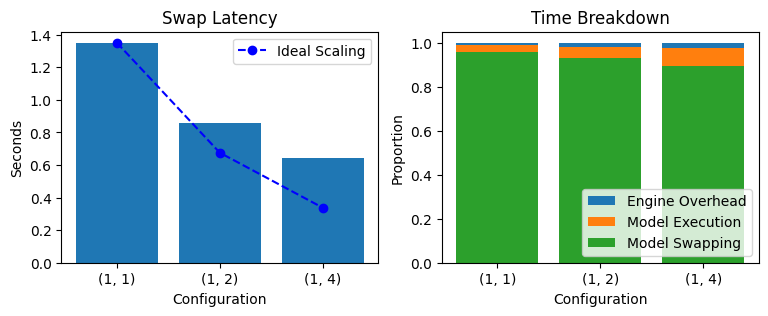

In [7]:
x = ["(1, 1)", "(1, 2)", "(1, 4)"]
mean_scale = mean_times[[0, 3, 4], :]
mean_resp = mean_scale[:, 3]

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
# axs[0].bar(x, mean_resp)
# axs[0].plot(x, [mean_resp[0] / i for i in [1, 2, 4]], color="blue", marker="o", linestyle="--", label="Ideal Scaling")
# axs[0].set_title("End-to-End Latency")
# axs[0].set_xlabel("Configuration")
# axs[0].set_ylabel("Seconds")
# axs[0].legend()

axs[0].bar(x, mean_scale[:, 1])
axs[0].plot(x, [mean_scale[0, 1] / i for i in [1, 2, 4]], color="blue", marker="o", linestyle="--", label="Ideal Scaling")
axs[0].set_title("Swap Latency")
axs[0].set_xlabel("Configuration")
axs[0].set_ylabel("Seconds")
axs[0].legend()

axs[1].bar(x, 1, label="Engine Overhead")
axs[1].bar(x, np.sum(mean_scale[:, 1:3], axis=1) / mean_resp, label="Model Execution")
axs[1].bar(x, mean_scale[:, 1] / mean_resp, label="Model Swapping")
axs[1].set_title("Time Breakdown")
axs[1].set_xlabel("Configuration")
axs[1].set_ylabel("Proportion")
axs[1].legend(loc="lower right")

plt.show()

#### 1.1.3 Scaling TP and PP

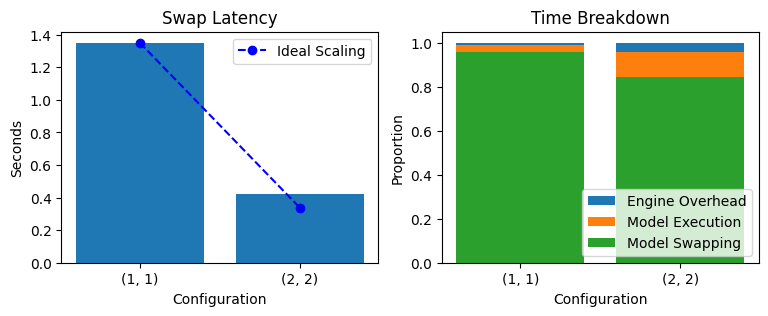

In [8]:
x = ["(1, 1)", "(2, 2)"]
mean_scale = mean_times[[0, 5], :]
mean_resp = mean_scale[:, 3]

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
# axs[0].bar(x, mean_resp)
# axs[0].plot(x, [mean_resp[0] / i for i in [1, 4]], color="blue", marker="o", linestyle="--", label="Ideal Scaling")
# axs[0].set_title("End-to-End Latency")
# axs[0].set_xlabel("Configuration")
# axs[0].set_ylabel("Seconds")
# axs[0].legend()

axs[0].bar(x, mean_scale[:, 1])
axs[0].plot(x, [mean_scale[0, 1] / i for i in [1, 4]], color="blue", marker="o", linestyle="--", label="Ideal Scaling")
axs[0].set_title("Swap Latency")
axs[0].set_xlabel("Configuration")
axs[0].set_ylabel("Seconds")
axs[0].legend()

axs[1].bar(x, 1, label="Engine Overhead")
axs[1].bar(x, np.sum(mean_scale[:, 1:3], axis=1) / mean_resp, label="Model Execution")
axs[1].bar(x, mean_scale[:, 1] / mean_resp, label="Model Swapping")
axs[1].set_title("Time Breakdown")
axs[1].set_xlabel("Configuration")
axs[1].set_ylabel("Proportion")
axs[1].legend(loc="lower right")

plt.show()

## 2. Simulated workloads

Run the `sim.py` script with different arguments for different experiment parameters.

```sh
python round_robin.py MODEL_NAME [-c CONFIG_INDEX] [-t TP_WORLD_SIZE] [-p PP_WORLD_SIZE] [-b BATCH_SIZE] [-d DURATION]
```

Then run the cells below to extract time data from logs.

For reference, Perlmutter GPU nodes have 4x A100 GPUs per mode, each with a PCIe 4.0 x16 CPU-GPU link that has 32 GB/s bandwidth.

In [2]:
def get_resp_times(log_file):
    resp_ids = []
    resp_times = []
    with open(log_file, 'r') as file:
        for line in file:
            if 'response' in line:
                match = re.search(r'model: (.+), response time: (\d+\.\d+)', line)
                try:
                    resp_ids.append(match.group(1))
                    resp_times.append(float(match.group(2)))
                except: pass
    return np.array(resp_ids), np.array(resp_times)


def plot_histogram(data):
    heights, bins = np.histogram(data, bins=10)
    heights = heights / sum(heights)
    plt.bar(bins[:-1], heights, width=(max(bins) - min(bins))/len(bins))


def plot_cdf(ax, data, label):
    x = np.sort(data)
    y = 1. * np.arange(len(data)) / (len(data) - 1)
    ax.plot(x, y, label=label)

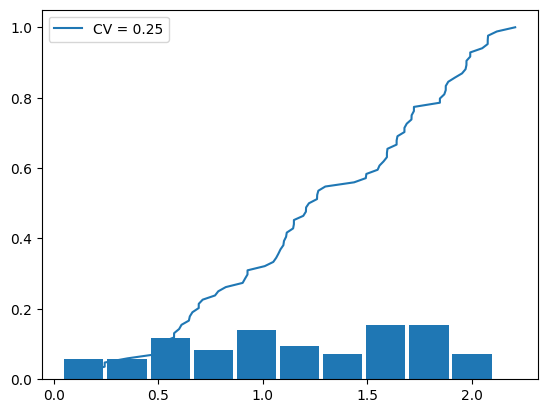

In [8]:
log_file = "sim_opt-13b_c0_t2_p2_b8_d30/client.log"
resp_ids, resp_times = get_resp_times(log_file)
plot_histogram(resp_times)
plot_cdf(plt, resp_times, label="CV = 0.25")
plt.legend()
plt.show()

1.2615934456095976
0.6057218389308199
0.5175510443173922
1.1721814147188516
0.8861485387458176
0.5504959956241717
1.0142914420855191
0.7163893842859886
0.37400690697279


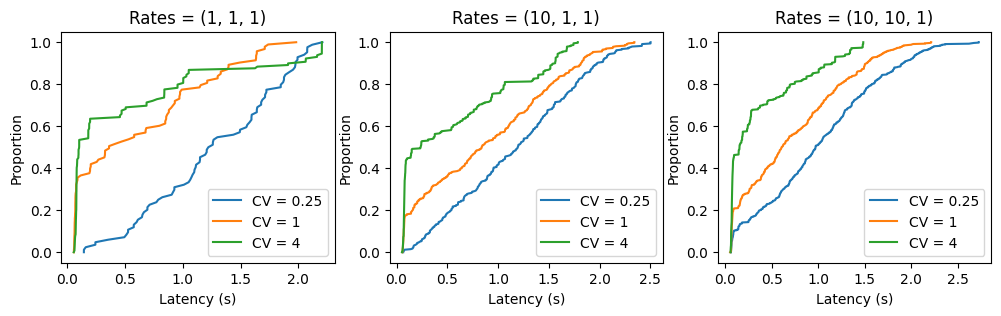

In [9]:
# batch_size = 8
rates = [(1, 1, 1), (10, 1, 1), (10, 10, 1)]

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
for i, ax in enumerate(axs):
    log_file = f"sim_opt-13b_c{3*i}_t2_p2_b8_d30/client.log"
    resp_ids, resp_times = get_resp_times(log_file)
    plot_cdf(ax, resp_times, label="CV = 0.25")
    print(np.mean(resp_times))

    log_file = f"sim_opt-13b_c{3*i+1}_t2_p2_b8_d30/client.log"
    resp_ids, resp_times = get_resp_times(log_file)
    plot_cdf(ax, resp_times, label="CV = 1")
    print(np.mean(resp_times))

    log_file = f"sim_opt-13b_c{3*i+2}_t2_p2_b8_d30/client.log"
    resp_ids, resp_times = get_resp_times(log_file)
    plot_cdf(ax, resp_times, label="CV = 4")
    print(np.mean(resp_times))
    
    ax.set_title(f"Rates = {rates[i]}")
    ax.set_xlabel("Latency (s)")
    ax.set_ylabel("Proportion")
    ax.legend(loc="lower right")

plt.show()

1.8466321607915366
1.2824062592741372
0.17361130634275804
2.0172289232922416
1.4125795250375157
0.22889208503769523
1.534933141915195
1.469779867483369
0.3120475583308645


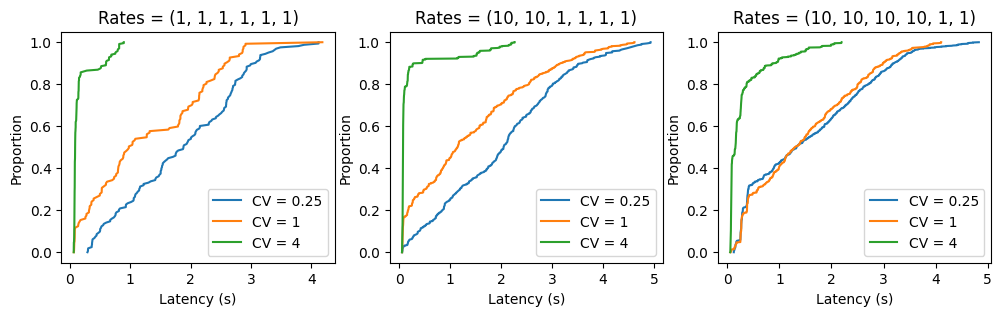

In [24]:
# batch_size = 32
rates = [(1, 1, 1, 1, 1, 1), (10, 10, 1, 1, 1, 1), (10, 10, 10, 10, 1, 1)]

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
for i, ax in enumerate(axs):
    log_file = f"sim_opt-13b_c{3*i+9}_t2_p2_b32_d30/client.log"
    resp_ids, resp_times = get_resp_times(log_file)
    plot_cdf(ax, resp_times, label="CV = 0.25")
    print(np.mean(resp_times))

    log_file = f"sim_opt-13b_c{3*i+10}_t2_p2_b32_d30/client.log"
    resp_ids, resp_times = get_resp_times(log_file)
    plot_cdf(ax, resp_times, label="CV = 1")
    print(np.mean(resp_times))

    log_file = f"sim_opt-13b_c{3*i+11}_t2_p2_b32_d30/client.log"
    resp_ids, resp_times = get_resp_times(log_file)
    plot_cdf(ax, resp_times, label="CV = 4")
    print(np.mean(resp_times))
    
    ax.set_title(f"Rates = {rates[i]}")
    ax.set_xlabel("Latency (s)")
    ax.set_ylabel("Proportion")
    ax.legend(loc="lower right")

plt.show()